# First pass at image processing

1. Motion correction (FIJI > Plugins > Registration > Linear Stack Alignment with SIFT, default settings)
2. Bleach correction (FIJI > Image > Adjust > Bleach Correction, Simple Ratio, Background = 0)
3. Load data into python, load ryan's sync pulse CSV to get the stim timing
4. for each stim pulse, average the stim pulse frames
5. for each stim pulse, collect a few pre-stim samples and average those
6. for each stim pulse, subtract pre-stim average from stim average
7. Average the subtracted images across however many trials we did

## Load image

In [42]:
import skimage as ski
import pandas as pd
import numpy as np

exp_name = 'right_blue'


if exp_name == 'spamming':
    img = ski.io.imread('/Users/ilya_arcadia/Neuroimaging_local/Processed/right_blue_spamming_1_MMStack_Default_aligned_bleachcorr.ome.tif')
    ignore_frames_beginning = 200 # ignore first N frames (due to motion etc)
    sync_file = pd.read_csv('/Users/ilya_arcadia/Neuroimaging_local/Processed/right_blue_spamming_processed.txt', index_col=0)
    n_bg_frames = 3
elif exp_name == 'right_blue':
    img = ski.io.imread('/Users/ilya_arcadia/Neuroimaging_local/Processed/right_blue_1_MMStack_Default_aligned_bleachcorr.ome.tif')
    ignore_frames_beginning = 0 # ignore first N frames (due to motion etc)
    sync_file = pd.read_csv('/Users/ilya_arcadia/Neuroimaging_local/Processed/right_blue_processed.txt', index_col=0)
    n_bg_frames = 100
elif exp_name == 'injection':
    img = ski.io.imread('/Users/ilya_arcadia/Neuroimaging_local/Processed/injection_blue_1_MMStack_Default_aligned_bleachcorr.ome.tif')
    ignore_frames_beginning = 0 # ignore first N frames (due to motion etc)
    sync_file = pd.read_csv('/Users/ilya_arcadia/Neuroimaging_local/Processed/injection_blue_processed.txt', index_col=0)
    n_bg_frames = 100
elif exp_name == 'whisker':
    img = ski.io.imread('/Users/ilya_arcadia/Neuroimaging_local/Processed/whisker_blue_1_MMStack_Default_aligned_bleachcorr.ome.tif') # ignore_frames_beginning = 0
    ignore_frames_beginning = 0 # ignore first N frames (due to motion etc)
    sync_file = pd.read_csv('/Users/ilya_arcadia/Neuroimaging_local/Processed/whisker_blue_processed.txt', index_col=0)
    n_bg_frames = 3
else:
    print('Unknown experiment name')

###### temp workaround to remove duplicate indices #######
# sync_file = sync_file[~sync_file.index.duplicated(keep='first')] # remove duplicate indices
# sync_file = sync_file.iloc[:-1] # remove last frame
###### temp workaround to remove duplicate indices #######

# calculate exposure times and frame rates
exp_ms = sync_file.iloc[:5]['frametime'].mean()*1000
framerate_hz = sync_file.iloc[:5]['framerate'].mean()

print('Exposure time (ms):', exp_ms)
print('Frame rate (Hz):', framerate_hz)
# sanity checks for sync file
assert len(sync_file) == len(img), 'Sync file and image length mismatch'

# remove first N frames to get rid of possible motion artifacts
img = img[ignore_frames_beginning:]


Exposure time (ms): 56.48000000000001
Frame rate (Hz): 17.705391300000002


In [38]:
# downsample image
DOWNSAMPLE_FACTOR = 2
from skimage.transform import resize
img = resize(img, (img.shape[0], img.shape[1] // DOWNSAMPLE_FACTOR, img.shape[2] // DOWNSAMPLE_FACTOR),
                       anti_aliasing=True)
print('Downsampled image shape: ', img.shape)

Downsampled image shape:  (1200, 350, 350)


## Load sync pulse data from DAQ

In [39]:
MIN_STIM_LENGTH = 3 # minimum length of pinch (in frames) to include


sync_file['pinch'] = sync_file['pinch'].astype(int) # convert pinch T/F col to 1/0

# find indices of sync pulse onset
onset_idx = sync_file.index[(np.diff(sync_file['pinch'], prepend=0) > 0)]
offset_idx = sync_file.index[(np.diff(sync_file['pinch'], prepend=0) < 0)]

stim_frames_start, stim_frames_end = [], []
for on, off in zip(onset_idx, offset_idx):
    if off - on > MIN_STIM_LENGTH and on > ignore_frames_beginning:
        stim_frames_start.append(on-ignore_frames_beginning)
        stim_frames_end.append(off-ignore_frames_beginning)
print('stim start: ', end='')
print(stim_frames_start)
print('stim end: ', end='')
print(stim_frames_end)

stim start: [173, 437, 698, 965]
stim end: [260, 524, 789, 1049]


## Process image

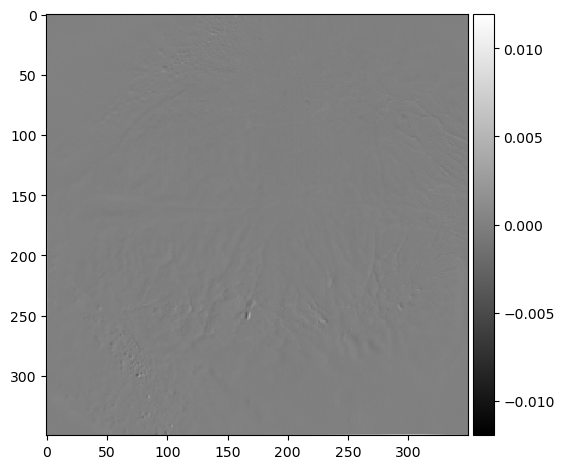

In [40]:
BG_STIM_DELAY = 2 # number of frames bw stim start and bg end
MAX_INTENSITY_DIFF = 1000 # ignore pixels with > N intensity difference because these are motion artifacts
imgs_subtracted = []
for s,e in zip(stim_frames_start, stim_frames_end):
    img_stim = img[s:e]
    img_bg = img[s-BG_STIM_DELAY-n_bg_frames:s-BG_STIM_DELAY]
    img_stim_avg = img_stim.mean(axis=0)
    img_bg_avg = img_bg.mean(axis=0)
    img_stim_avg_sub = img_stim_avg - img_bg_avg
    # remove outlier pixels
    img_stim_avg_sub[img_stim_avg_sub > MAX_INTENSITY_DIFF] = 0
    img_stim_avg_sub[img_stim_avg_sub < -MAX_INTENSITY_DIFF] = 0
    img_stim_avg_sub = img_stim_avg_sub - np.median(img_stim_avg_sub)
    imgs_subtracted.append(img_stim_avg_sub)

imgs_subtracted = np.array(imgs_subtracted)

ski.io.imshow(imgs_subtracted.mean(axis=0), cmap='gray') #, vmin=-50, vmax=50)
